## Convert `HDDM` model object to `ArviZ`

Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com

We will use the example from [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html), and tried to convert the `HDDM` object to `Arviz` `InferenceData`.

So far, I haven't finished the `prior` part and the `log likelihood` part.

Note: to conver the posterior predictive needs substantial amount of memory, make sure that your machine's RAM is large enough.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

# parallel processing related packages
from p_tqdm import p_map
from functools import partial

The current HDDM version is:  0.8.0


/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.8/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


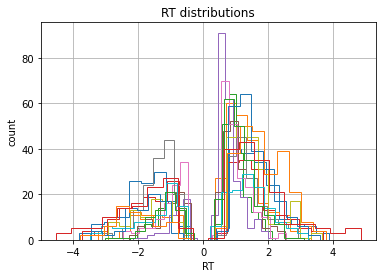

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

## Fitting a hierarchical model with four chains

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=500)
```

In [7]:
samples = 500 # number of samples for MCMC chain, 500 is used for quick demo 
burn = 200    # number of burn in    
thin = 1
chains = 4

In [8]:
# define a model
def model(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m"): 
    print('running model%i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # save the model data
    m.save(mname)
    
    return m

In [9]:
models = p_map(partial(model, data=data, samples=samples, burn=burn),
               range(chains)) # progess bar is a mess ;(

running model0


  0%|          | 0/4 [00:00<?, ?it/s]

running model1
running model2
running model3


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  1%                  ] 6 of 500 complete in 0.5 sec[                  1%                  ] 6 of 500 complete in 0.5 sec[                  1%                  ] 6 of 500 complete in 0.5 sec[                  1%                  ] 6 of 500 complete in 0.6 sec[                  2%                  ] 11 of 500 complete in 1.1 sec[                  2%                  ] 11 of 500 complete in 1.1 sec[                  2%                  ] 11 of 500 complete in 1.1 sec[                  2%                  ] 11 of 500 complete in 1.1 sec[-                 3%                  ] 16 of 500 complete in 1.6 sec[-                 3%                  ] 16 of 500 complete in 1.6 sec[-                 3%                  ] 16 of 500 complete in 1.6 sec[-                 3%                  ] 16 of 500 complete in 1.7 sec[-                 4%                  ] 21 of 500 complete in 2.2 sec[-                 4%                  ] 21 of 500 complete in 2.1 sec[-                 4%  

 [-----------      30%                  ] 151 of 500 complete in 16.0 sec[-----------      30%                  ] 151 of 500 complete in 16.3 sec[-----------      30%                  ] 151 of 500 complete in 16.3 sec[-----------      30%                  ] 152 of 500 complete in 16.2 sec[-----------      31%                  ] 156 of 500 complete in 16.5 sec[-----------      31%                  ] 156 of 500 complete in 16.9 sec[-----------      31%                  ] 156 of 500 complete in 16.9 sec[-----------      31%                  ] 157 of 500 complete in 16.8 sec[------------     32%                  ] 161 of 500 complete in 17.1 sec[------------     32%                  ] 161 of 500 complete in 17.4 sec[------------     32%                  ] 161 of 500 complete in 17.4 sec[------------     32%                  ] 162 of 500 complete in 17.3 sec[------------     33%                  ] 166 of 500 complete in 17.6 sec[------------     33%                  ] 166 of 500 complete in

 [-----------------58%--                ] 291 of 500 complete in 31.6 sec[-----------------58%--                ] 291 of 500 complete in 31.5 sec[-----------------59%--                ] 296 of 500 complete in 31.6 sec[-----------------59%--                ] 298 of 500 complete in 31.8 sec[-----------------59%--                ] 296 of 500 complete in 32.1 sec[-----------------59%--                ] 296 of 500 complete in 32.1 sec[-----------------60%--                ] 301 of 500 complete in 32.2 sec[-----------------60%---               ] 303 of 500 complete in 32.4 sec[-----------------60%--                ] 301 of 500 complete in 32.6 sec[-----------------60%--                ] 301 of 500 complete in 32.7 sec[-----------------61%---               ] 306 of 500 complete in 32.7 sec[-----------------61%---               ] 308 of 500 complete in 32.9 sec[-----------------61%---               ] 306 of 500 complete in 33.2 sec[-----------------61%---               ] 306 of 500 complete in

[-----------------100%-----------------] 501 of 500 complete in 54.6 secc[-----------------87%-------------     ] 438 of 500 complete in 47.0 sec[-----------------87%-------------     ] 436 of 500 complete in 47.1 sec[-----------------88%-------------     ] 441 of 500 complete in 47.3 sec[-----------------87%-------------     ] 436 of 500 complete in 47.6 sec[-----------------88%-------------     ] 443 of 500 complete in 47.5 sec[-----------------88%-------------     ] 441 of 500 complete in 47.7 sec[-----------------89%-------------     ] 446 of 500 complete in 47.8 sec[-----------------88%-------------     ] 441 of 500 complete in 48.2 sec[-----------------89%--------------    ] 448 of 500 complete in 48.0 sec[-----------------89%-------------     ] 446 of 500 complete in 48.2 sec[-----------------90%--------------    ] 451 of 500 complete in 48.4 sec[-----------------89%-------------     ] 446 of 500 complete in 48.7 sec  [-----------------90%--------------    ] 453 of 500 complete 

In [10]:
# Uncomment the code below if you already stored the model objects:
# m_stim_list = []
# exp_name = 'cavanagh2011'
# model_tag = 'm'
# for i in range(4):
#     mname  = '/home/jovyan/example/df_' + exp_name + '_' + model_tag + '_chain_%i'%i 
#     print(mname)
#     m = hddm.load(mname)
#     m_stim_list.append(m)

#### prepare the posterior predictive

Need to be parallalized in the future.

* Note 1: the number of sample is consistent with posterior
* Note 2: this part eats a lot of memory, keep the number of sample small at beginning.

In [11]:
df_stim_post_preds = []
for i in range(4):
    m = models[i]
    df_post_pred = hddm.utils.post_pred_gen(m, samples = 1000) # number of samples can be reduced (?)
    df_post_pred.reset_index(inplace=True)
    df_post_pred['chain'] = i
    df_post_pred.rename(columns={'sample':'draw',
                                 'level_2':'trial'}, inplace=True)
    print('\nchain', i, df_post_pred.shape)
    df_stim_post_preds.append(df_post_pred)

# delete interim variables to save memory
del m
del df_post_pred

 [------------------107%------------------] 45 of 42 complete in 508.4 sec
chain 0 (3988000, 6)
 [---               9%                  ] 4 of 42 complete in 11.8 sec

KeyboardInterrupt: 

## Convert HDDM objects to ArviZ

Let's try to compare `m_stim_list` and `m_reg_list` in the above models.

To convert a `HDDM` object to an `ArviZ` InferenceData and use all the functionality of `ArviZ`, we need to convert the following parts (see more details about Ariviz InferenceData [here](https://arviz-devs.github.io/arviz/schema/schema.html#posterior-predictive)):

* observed_data: the data on which the posterior is conditional. Each variable should have a counter part.

* Posterior: Samples from the posterior distribution $p(\theta | y)$, which is the trace from pymc.

* posterior_predictive: the posterior predictive distribution evaluated at the `observed_data`. Samples should match with `posterior` ones and its variables should match `observed_data` variables. The `observed_data` counterpart variable may have a different name.

* **sample_stats**: Information and diagnostics for each `posterior` sample, provided by the inference backend.

* **log_likelihood**: pointwise log likelihood data. Sample shoudl match with `posteior` ones and its variables should match `observed_data` variables.

* **prior**: Samples from the prior distriubtion $p(\theta)$. Samples need not to match `posterior`. still follow the convertion on `chain` and `draw` as first dimensions.

* **prior_predictive**: Samples from the `prior` predictive distribution. Samples should match `prior` samples and each variable should have a counterpart in `posterior_predictive/observed_data`.


So far, I converted the observed data, posterior, and posterior predictive. We can use the plot function from ArviZ.

For model evaluation functions of `ArviZ`, which need `log likelihood`, has been converted yet. That said, `az.loo()` and `az.waic()` is not supported yet.

In [ ]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

In [ ]:
print("DIC of m_depends_on is %.5f" % models[0].dic)

### `observed_data`

In this example data, we have 14 participants, each with three different conditions, each condition has different trial numbers.

In [ ]:
data.groupby(['subj_idx', 'stim']).size()

Here I created an temporary data to store the observed data and then converted it to `xarrage` data.

In [ ]:
data_tmp = data.copy()
data_tmp['trial'] = data_tmp.groupby(['subj_idx', 'stim']).cumcount()
data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
data_tmp.head()

In [ ]:
data_tmp = data_tmp.set_index(["subj_idx", "stim", 'trial'])
xdata_observed = xr.Dataset.from_dataframe(data_tmp)
xdata_observed

### `posterior`
The `posterior` are from the traces

In [ ]:
df_stim_traces = []
for i in range(4):
    m = models[i]
    df_trace = m.get_traces()
    df_trace['chain'] = i
    df_trace['draw'] = np.arange(len(df_trace), dtype=int)
    print('chain', i, df_trace.shape)
    df_stim_traces.append(df_trace)
df_stim_traces = pd.concat(df_stim_traces)
df_stim_traces = df_stim_traces.set_index(["chain", "draw"])

In [ ]:
xposterior_stim = xr.Dataset.from_dataframe(df_stim_traces)
xposterior_stim

### `posterior_predictive`


In [ ]:
df_stim_ppc = []
for i in range(4):
    df_post_pred = df_stim_post_preds[i]
    df_post_pred['chain'] = i
    # df_post_pred['draw'] = np.arange(len(df), dtype=int)
    # print('chain', i, df.shape)
    df_post_pred[['stim', 'subj_idx']] = df_post_pred['node'].str.split(pat='\.', expand=True)

    # extract the stim string between "(" and ")"

    df_post_pred['stim'] = df_post_pred['stim'].str.extract('.*\((.*)\).*')
    df_post_pred.drop('node', axis=1, inplace=True)
    df_stim_ppc.append(df_post_pred)

# df_stim_ppc = df_stim_traces.set_index(["chain", "draw"])

In [ ]:
del df_post_pred

In [ ]:
df_stim_ppc = pd.concat(df_stim_ppc)
df_stim_ppc.head()

In [ ]:
df_stim_ppc = df_stim_ppc.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
xdata_post_pred = xr.Dataset.from_dataframe(df_stim_ppc) # also eat memory here
xdata_post_pred

In [ ]:
InfData_stim = az.InferenceData(posterior=xposterior_stim, observed_data=xdata_observed,
                                posterior_predictive=xdata_post_pred)

InfData_stim

In [ ]:
from arviz.utils import Numba
Numba.disable_numba() # Numba has comptability issue see: https://github.com/pymc-devs/pymc/issues/4570
Numba.numba_flag

az.plot_trace(InfData_stim)

In [ ]:
# plot traces
az.plot_trace(InfData_stim, var_names=("^a"), filter_vars='regex', rug=True, kind="rank_bars")

In [ ]:
az.plot_forest(InfData_stim)

In [ ]:
az.hdi(InfData_stim)

In [ ]:
# plot ppc
az.plot_ppc(InfData_stim)

### Tried to draw from prior (failed)

In [ ]:
tmp = m_stim_list[0]
draw_from_prior(tmp, update=False)
# tmp.draw_from_prior(update=False)

In [ ]:
df_stim_priors = []
for i in range(4):
    df = models[i]
    df_prior = df.draw_from_prior()
    df_prior['chain'] = i
    df_prior['draw'] = np.arange(len(df_prior), dtype=int)
    print('chain', i, df_prior.shape)
    df_priors.append(df_trace)
df_stim_priors = pd.concat(df_stim_priors)
df_stim_priors = df_stim_priors.set_index(["chain", "draw"])